In [1]:
import numpy as np
import xlrd
import pandas as pd
import matplotlib.pyplot as plt
import molmass

# Gathering Data

In [125]:
# reading_data
data_wb = xlrd.open_workbook('CHE223-Assignment1 for 2023-data sets up to 2019.xls')

# Finding Columns of Ions and Postal Codes
ion_dict = {}
postal_code = {}
all_ions = set()

for sheet in data_wb.sheets():

    year = ''
    for char in sheet.name:
        if char.isdigit(): year += char
    year = int(year)

    ions = []
    for row in np.arange(11):
        for col in np.arange(sheet.ncols):
            value = sheet.cell_value(row,col)

            if type(value) is str:
                if len(value)<=3:
                    try :
                        molmass.Formula(value)._elements
                        ions.append((year, col, row, value))
                        all_ions.add(value)
                    except: pass
                elif 'postal' in value.lower():
                    postal_code[sheet] = col

    ion_dict[sheet] = ions
    

In [185]:
# iterate through rows and record values based on (column, ion) pairs

data = []

for sheet in data_wb.sheets():
    for i in np.arange(len(ion_dict[sheet])):

        ion_tuple = ion_dict[sheet][i]
        for row in np.arange(ion_dict[sheet][i][2]+1, sheet.nrows):

            value = sheet.cell_value(row,ion_dict[sheet][i][1])

            # Data cleaning
            if type(value) is str:
                if 'n' in value.lower() or '-' in value or value.strip() == '':
                    value = np.nan
                
                elif value.endswith('ppm'):
                    value = float(value.strip('ppm'))

                elif '..' in value:
                    value = float(value.replace('..','.'))

                elif '. ' in value:
                    value = float(value.replace('. ','.'))
                
                elif '^' in value:
                    value = float(value[0:4]) * 10 ** int(value[-1])

            if sheet in postal_code:
                pocode = sheet.cell_value(row, postal_code[sheet]).strip().upper()[0:3]
                
                if pocode.strip() == '':
                    pocode = np.nan

            else:
                pocode = np.nan
            
            # Empty entries and negative entries  are excluded immediately 
            if value is not np.nan and not value < 0:
                data.append([ion_tuple[0], ion_tuple[3], value, pocode])



df = pd.DataFrame(data, columns=['Year', 'Ion', 'Conc (mg/L)', 'Postal Code'])

In [178]:
df[df['Ion']=='Fe'].head()

,Year,Ion,Conc (mg/L),Postal Code
128,2018,Fe,0.01,M5G
129,2018,Fe,0.00,L1V
130,2018,Fe,0.01,M5S
131,2018,Fe,0.01,M9B
132,2018,Fe,0.00,M5A


C:\Users\enlb2\AppData\Local\Temp\ipykernel_89132\2715031736.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


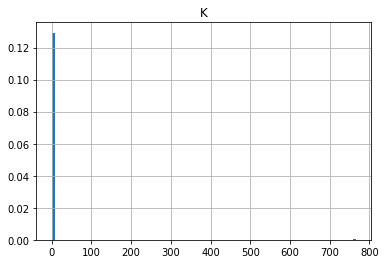

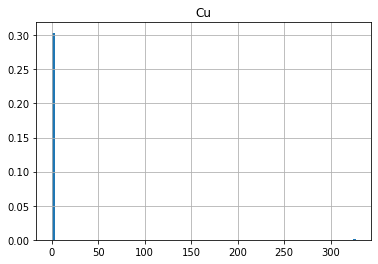

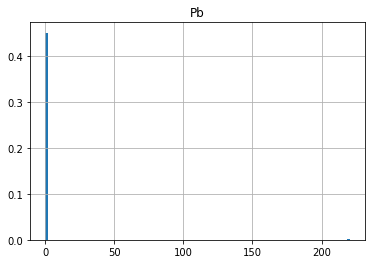

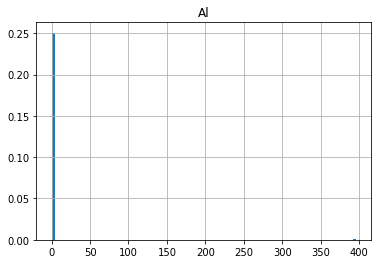

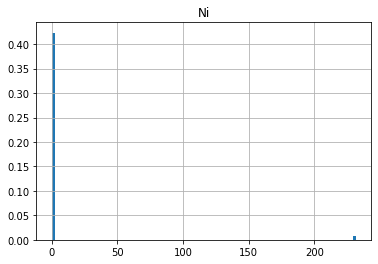

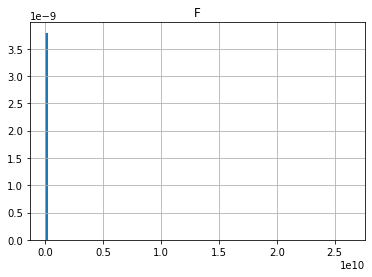

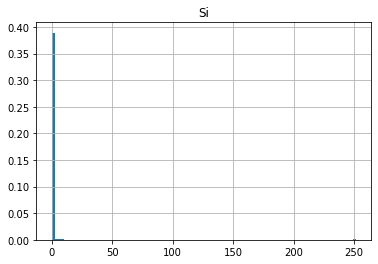

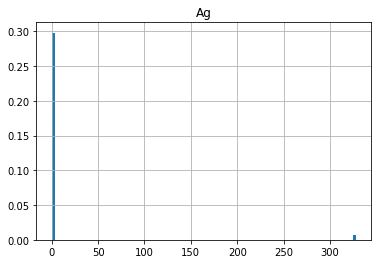

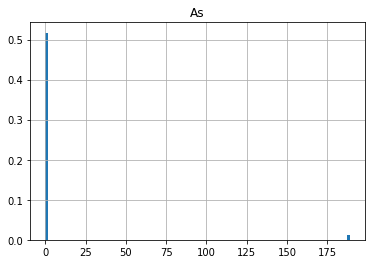

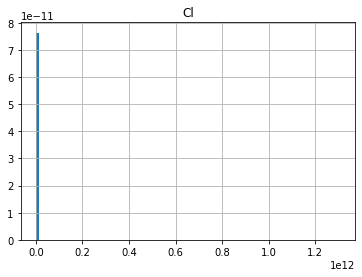

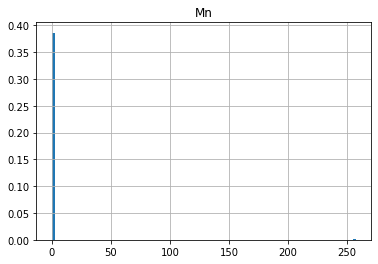

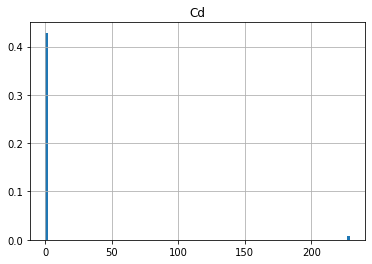

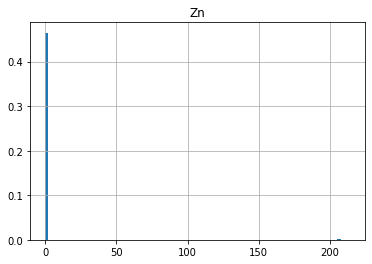

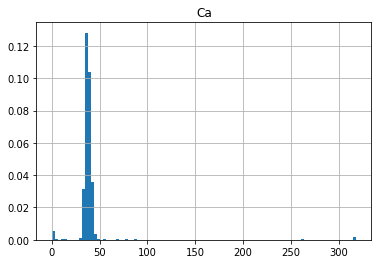

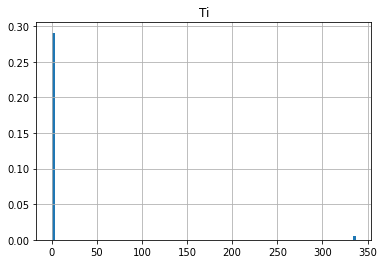

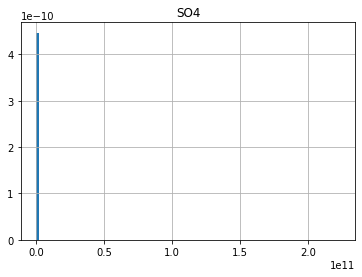

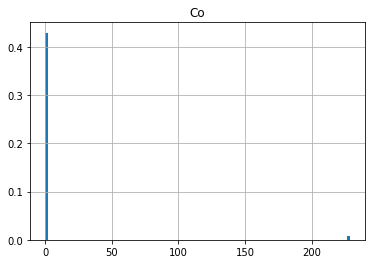

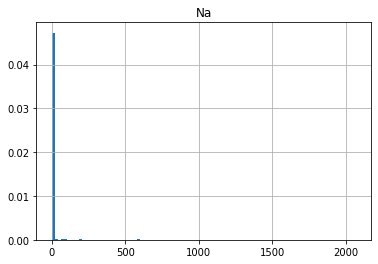

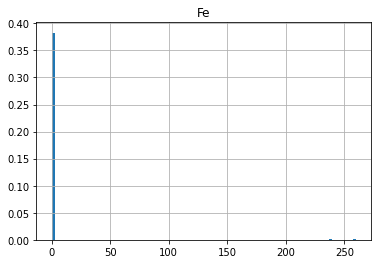

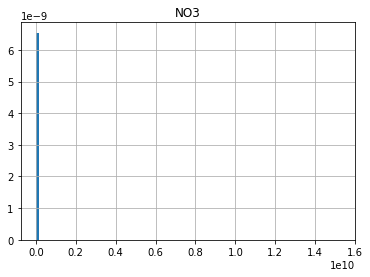

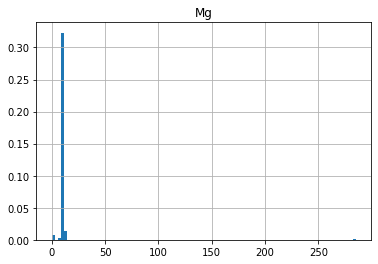

In [224]:
# Removing outliers
for ion in all_ions:
    plt.figure()
    plt.title(ion)
    df[(df['Ion'] == ion)]['Conc (mg/L)'].hist(cumulative=False, density=1, bins=100)

# Plots

c:\Users\enlb2\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


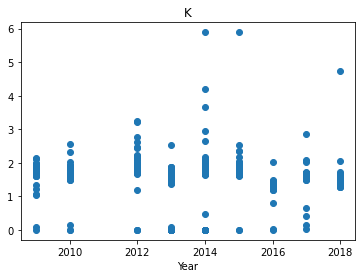

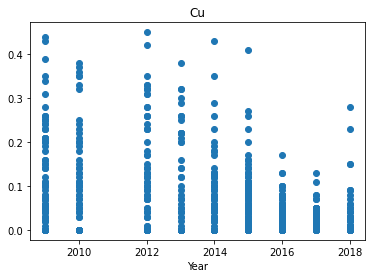

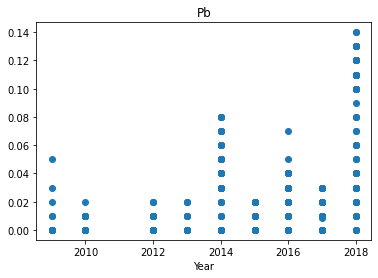

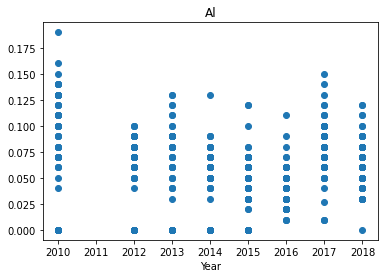

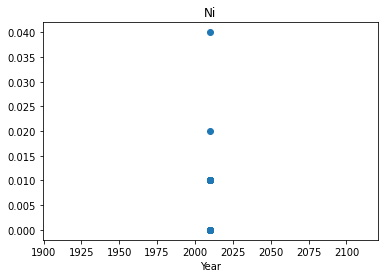

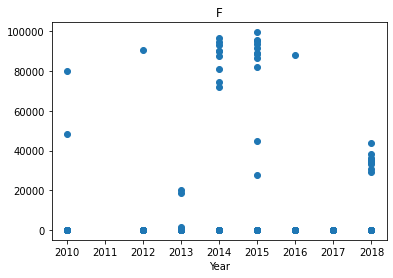

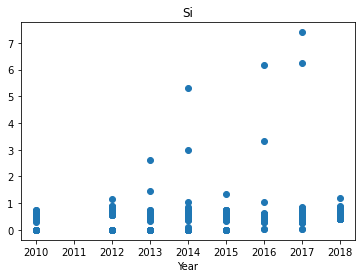

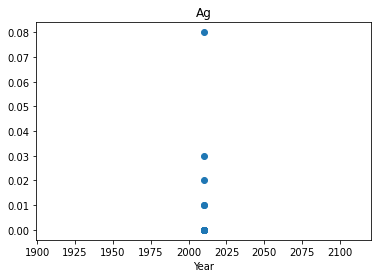

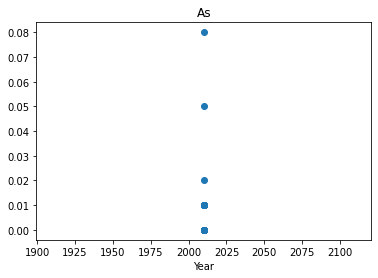

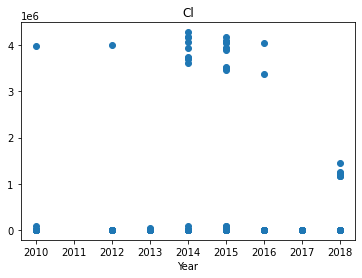

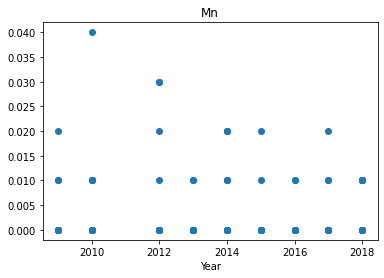

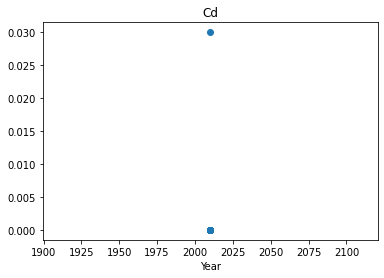

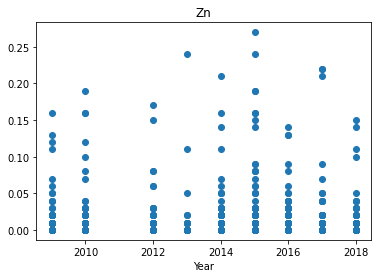

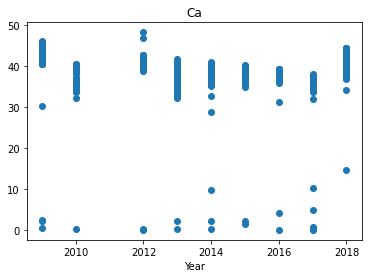

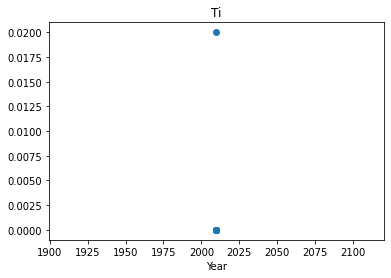

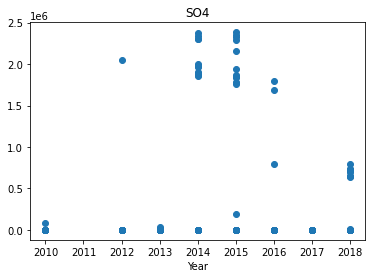

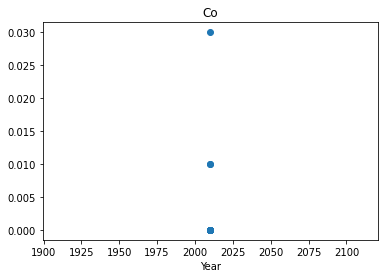

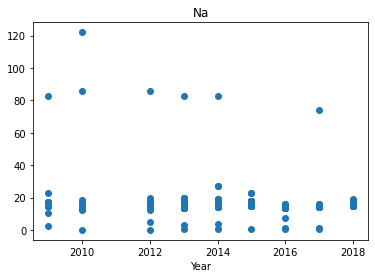

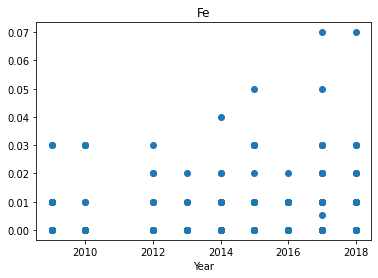

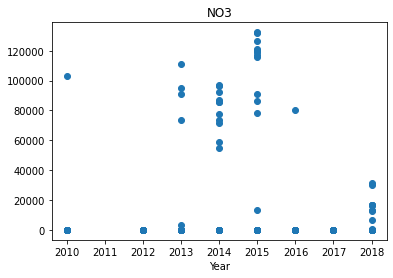

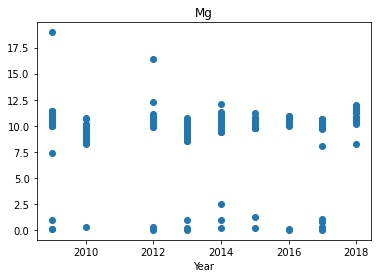

In [225]:
for ion in all_ions:
    df[(df['Ion'] == ion) & (df['Conc (mg/L)'] < df[(df['Ion'] == ion)]['Conc (mg/L)'].quantile(0.99))].plot(x='Year', y='Conc (mg/L)', ls='', marker='o', title=ion, legend=None)